In [0]:
# Load all .parquet files from the local 'data/' folder

import os

data_folder = "data"
parquet_files = [f for f in os.listdir(data_folder) if f.endswith(".parquet")]

df_all = None
for file in parquet_files:
    full_path = os.path.join(data_folder, file)
    df = spark.read.parquet(full_path)
    df_all = df if df_all is None else df_all.union(df)

print("Total number of rows loaded:", df_all.count())


Total number of rows:: 3473


In [0]:
# Check for null values and duplicates by column, uniqueness of 'Unit', date range, and negative values
from pyspark.sql.functions import col, count, when, min, max

# Count null values per column
df_all.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_all.columns
]).show()

# Check for duplicates
original_count = df_all.count()
deduplicated_count = df_all.dropDuplicates().count()

print("Number of rows before removing duplicates:", original_count)
print("Number of rows after removing duplicates:", deduplicated_count)

# Check for noise or inconsistencies in the 'Unit' column
df_all.select("Unit").distinct().show()

# Check minimum and maximum dates in the 'Start' column
df_all.select(min("Start").alias("Earliest Start"), max("Start").alias("Latest Start")).show()

# Check for negative measurement values
negative_count = df_all.filter(col("Value") < 0).count()
print("Number of negative 'Value' entries:", negative_count)


+-------------+---------+-----+---+-----+----+-------+--------+------------+----------+-----------+----------------+
|Samplingpoint|Pollutant|Start|End|Value|Unit|AggType|Validity|Verification|ResultTime|DataCapture|FkObservationLog|
+-------------+---------+-----+---+-----+----+-------+--------+------------+----------+-----------+----------------+
|            0|        0|    0|  0|    0|   0|      0|       0|           0|         0|       3473|               0|
+-------------+---------+-----+---+-----+----+-------+--------+------------+----------+-----------+----------------+

Number of rows before removing duplicates: 3473
Number of rows after removing duplicates: 3473
+------+
|  Unit|
+------+
|ug.m-3|
+------+

+-------------------+-------------------+
|     Earliest Start|       Latest Start|
+-------------------+-------------------+
|2023-01-01 00:00:00|2023-12-30 00:00:00|
+-------------------+-------------------+

Number of negative 'Value' entries: 0


In [0]:
# Select key columns for analysis
from pyspark.sql.functions import col

df_clean = df_all.select(
    col("Samplingpoint"),
    col("Start"),
    col("Value")
)

# Display the first 10 rows from the cleaned DataFrame
df_clean.show(10, truncate=False)


+------------------------+-------------------+--------------------+
|Samplingpoint           |Start              |Value               |
+------------------------+-------------------+--------------------+
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-01 00:00:00|5.505000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-02 00:00:00|4.816000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-03 00:00:00|5.034000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-04 00:00:00|3.972000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-05 00:00:00|4.000000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-06 00:00:00|3.582000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-07 00:00:00|3.873000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-08 00:00:00|2.848000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-09 00:00:00|0.671000000000000000|
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-10 00:00:00|1.923000000000000000|
+------------------------+-------------------+--------------------+
only showing top 10 rows



In [0]:
# Group by date only (strip time from 'Start') and calculate daily average pollution value

from pyspark.sql.functions import avg, to_date

df_avg_daily = (
    df_clean
    .withColumn("Date", to_date("Start"))  # Add a new column that contains only the date (without time)
    .groupBy("Date")                        # Group all records by date (ignoring time and sampling location)
    .agg(avg("Value").alias("Avg_PM25"))   # For each day, calculate the average pollution value (PM2.5)
)

# Display the first 10 rows, sorted by date
df_avg_daily.orderBy("Date").show(10)


+----------+--------------------+
|      Date|            Avg_PM25|
+----------+--------------------+
|2023-01-01|24.97344444444444...|
|2023-01-02|16.54544444444444...|
|2023-01-03|20.51644444444444...|
|2023-01-04|22.19000000000000...|
|2023-01-05|20.92288888888888...|
|2023-01-06|28.65966666666666...|
|2023-01-07|25.54933333333333...|
|2023-01-08|16.79000000000000...|
|2023-01-09|7.355444444444444...|
|2023-01-10|5.946000000000000...|
+----------+--------------------+
only showing top 10 rows



In [0]:
# Calculate overall minimum, maximum, and average PM2.5 values

from pyspark.sql.functions import min, max, avg

df_clean.select(
    min("Value").alias("Min_PM25"),
    max("Value").alias("Max_PM25"),
    avg("Value").alias("Avg_PM25")
).show()


+--------------------+--------------------+--------------------+
|            Min_PM25|            Max_PM25|            Avg_PM25|
+--------------------+--------------------+--------------------+
|0.478000000000000000|129.0400000000000...|13.04574632882234...|
+--------------------+--------------------+--------------------+



In [0]:
# Show all high PM2.5 values (>100) and the stations that recorded them
df_clean.filter(col("Value") > 100) \
    .select("Samplingpoint", "Start", "Value") \
    .orderBy("Value", ascending=False) \
    .show(20, truncate=False)

# Count how many times each station recorded values >100
df_clean.filter(col("Value") > 100) \
    .groupBy("Samplingpoint") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(truncate=False)


+------------------------+-------------------+----------------------+
|Samplingpoint           |Start              |Value                 |
+------------------------+-------------------+----------------------+
|HR/HR_DOC_TYPE_D_SPO_749|2023-12-30 00:00:00|129.040000000000000000|
|HR/HR_DOC_TYPE_D_SPO_749|2023-12-26 00:00:00|108.182000000000000000|
|HR/HR_DOC_TYPE_D_SPO_749|2023-12-20 00:00:00|107.538000000000000000|
|HR/HR_DOC_TYPE_D_SPO_749|2023-12-29 00:00:00|105.570000000000000000|
|HR/HR_DOC_TYPE_D_SPO_749|2023-12-28 00:00:00|104.445000000000000000|
|HR/HR_DOC_TYPE_D_SPO_749|2023-11-30 00:00:00|101.914000000000000000|
+------------------------+-------------------+----------------------+

+------------------------+-----+
|Samplingpoint           |count|
+------------------------+-----+
|HR/HR_DOC_TYPE_D_SPO_749|6    |
+------------------------+-----+



In [0]:
# Group by measurement station and calculate average PM2.5 value
from pyspark.sql.functions import avg

df_avg_by_location = df_clean.groupBy("Samplingpoint") \
    .agg(avg("Value").alias("Avg_PM25"))

# Show top 10 most polluted locations (sorted by average PM2.5 descending)
df_avg_by_location.orderBy("Avg_PM25", ascending=False) \
    .show(10, truncate=False)


+-------------------------+-------------------------+
|Samplingpoint            |Avg_PM25                 |
+-------------------------+-------------------------+
|HR/HR_DOC_TYPE_D_SPO_749 |26.8046344410876132930514|
|HR/HR_DOC_TYPE_D_SPO_795 |17.8230257142857142857143|
|HR/HR_DOC_TYPE_D_SPO_1214|17.8230257142857142857143|
|HR/HR_DOC_TYPE_D_SPO_1028|14.2683240223463687150838|
|HR/HR_DOC_TYPE_D_SPO_676 |12.2935576923076923076923|
|HR/HR_DOC_TYPE_D_SPO_921 |10.2553166666666666666667|
|HR/HR_DOC_TYPE_D_SPO_1064|9.0869107806691449814126 |
|HR/HR_DOC_TYPE_D_SPO_941 |7.7906942148760330578512 |
|HR/HR_DOC_TYPE_D_SPO_1136|7.6663983516483516483516 |
|HR/HR_DOC_TYPE_D_SPO_748 |7.2022692307692307692308 |
+-------------------------+-------------------------+



In [0]:
# Label air quality based on PM2.5 value using standard AQI categories
from pyspark.sql.functions import when, col

df_labeled = df_clean.withColumn(
    "AirQuality",
    when(col("Value") <= 12.0, "Good")
    .when(col("Value") <= 35.4, "Moderate")
    .when(col("Value") <= 55.4, "Sensitive")
    .when(col("Value") <= 150.4, "Unhealthy")
    .when(col("Value") <= 250.4, "Very Unhealthy")
    .otherwise("Hazardous")
)

# Show first 30 labeled rows
df_labeled.show(30, truncate=False)


+------------------------+-------------------+---------------------+----------+
|Samplingpoint           |Start              |Value                |AirQuality|
+------------------------+-------------------+---------------------+----------+
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-01 00:00:00|5.505000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-02 00:00:00|4.816000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-03 00:00:00|5.034000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-04 00:00:00|3.972000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-05 00:00:00|4.000000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-06 00:00:00|3.582000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-07 00:00:00|3.873000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-08 00:00:00|2.848000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-09 00:00:00|0.671000000000000000 |Good      |
|HR/HR_DOC_TYPE_D_SPO_748|2023-01-10 00:

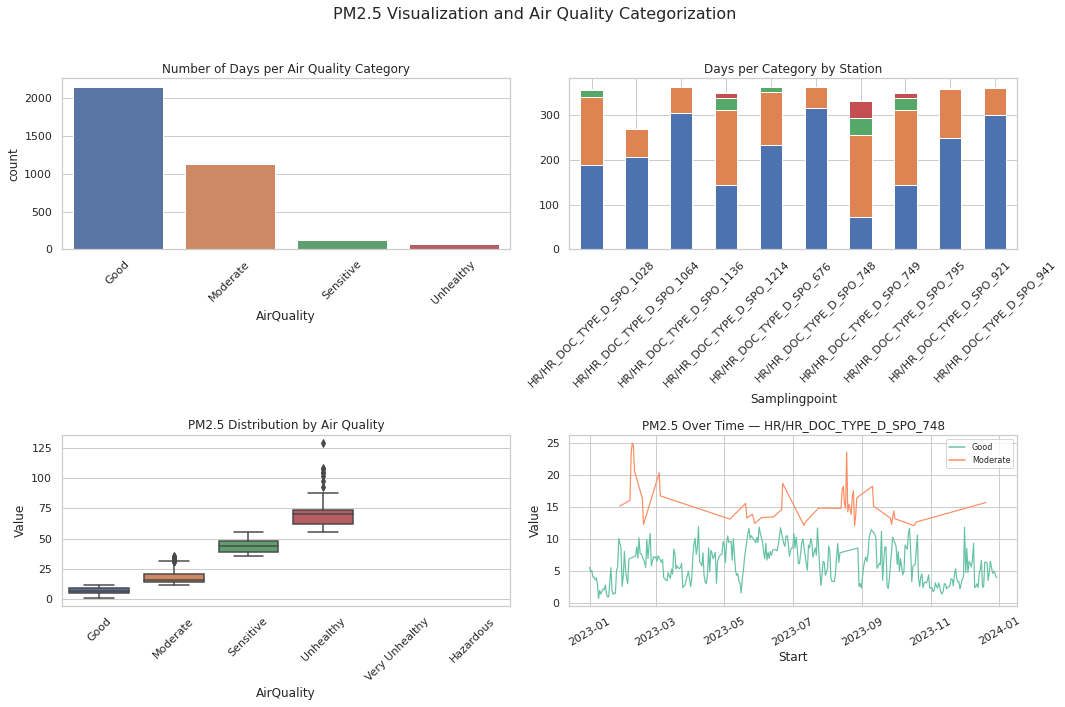

In [0]:
# Visualization of PM2.5 and air quality categories
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType

# Cast the Decimal column to float (DoubleType) to avoid Pandas conversion warning
df_labeled = df_labeled.withColumn("Value", col("Value").cast(DoubleType()))

# Then convert to Pandas
pdf = df_labeled.toPandas()

# Count of days by station and air quality
counts = pdf.groupby(["Samplingpoint", "AirQuality"]).size().unstack(fill_value=0)

# Select station for line chart visualization
station_name = "HR/HR_DOC_TYPE_D_SPO_748"

# Filter data for the selected station, sorted by date
station_df = pdf[pdf["Samplingpoint"] == station_name].sort_values("Start")

# Convert 'Value' to float in case of Decimal types
pdf["Value"] = pdf["Value"].astype(float)

# Drop rows with NaN in relevant columns for boxplot
pdf_box = pdf[["AirQuality", "Value"]].dropna()

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("PM2.5 Visualization and Air Quality Categorization", fontsize=16)

# 1. Count of days per Air Quality category (global)
sns.countplot(data=pdf, x="AirQuality", order=pdf["AirQuality"].value_counts().index, ax=axs[0, 0])
axs[0, 0].set_title("Number of Days per Air Quality Category")
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Stacked bar chart: days per category per station
counts.plot(kind="bar", stacked=True, ax=axs[0, 1], legend=False)
axs[0, 1].set_title("Days per Category by Station")
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Boxplot of PM2.5 distribution by Air Quality
sns.boxplot(data=pdf_box, x="AirQuality", y="Value",
            order=["Good", "Moderate", "Sensitive", "Unhealthy", "Very Unhealthy", "Hazardous"],
            ax=axs[1, 0])
axs[1, 0].set_title("PM2.5 Distribution by Air Quality")
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Line plot of PM2.5 over time for selected station
sns.lineplot(data=station_df, x="Start", y="Value", hue="AirQuality",
             ax=axs[1, 1], palette="Set2", linewidth=1.2)
axs[1, 1].set_title(f"PM2.5 Over Time — {station_name}")
axs[1, 1].tick_params(axis='x', rotation=30)
axs[1, 1].legend(fontsize=8, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


            Value
season           
Winter  20.202828
Spring  10.939376
Summer  10.181798
Autumn  11.538164


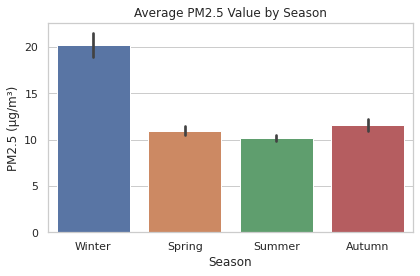

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Start' is in datetime format
pdf["Start"] = pd.to_datetime(pdf["Start"])

# Extract month from the date
pdf["month"] = pdf["Start"].dt.month

# Map each month to its corresponding season (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Create 'season' column
pdf["season"] = pdf["month"].apply(get_season)

# Compute average PM2.5 per season and ensure correct seasonal order
season_pivot = pdf.pivot_table(values="Value", index="season", aggfunc="mean").reindex(["Winter", "Spring", "Summer", "Autumn"])
print(season_pivot)

# Plot seasonal average PM2.5
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
sns.barplot(data=pdf, x="season", y="Value", order=["Winter", "Spring", "Summer", "Autumn"])
plt.title("Average PM2.5 Value by Season")
plt.xlabel("Season")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()
